## Downscaling Hourly NECOFS Data for Survey Strata on Days when MENH Survey Stations are Sampled

As preparation for pulling this information in python, I've taken a few steps preparing some materials to keep things organized and make it easy to pull the right information.

There are three files that were prepared, and they hold the following information:

 1. `MENH_strata_date_coverage.csv` Tells us which strata were sampled on which date. This will tell us whether or not we need data for any given dates that may be in the FVCOM files.
 2. `MENH_strata_GOM4_overlap_indices.csv` Tells us the mesh indexing details to pull data with for each strata. If a strata was sampled that day, this file contains all the nodes we will need to pull data from.

I'm switching to python for 2 functionalities which are more performant in using `xarray` than R's `ncdf4` package.

 1. The first is the ability to pass a list of index positions to subset data using `xr_dataset.isel(node = nodes_x)`
 2. The second is the ability to downscale from hourly to daily without mucking about with datetime strings.

In [1]:
# Libraries
import xarray as xr
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Path to Box Assets
box_root = "/Users/adamkemberling/Library/CloudStorage/Box-Box/"
lob_ecol_path = f"{box_root}Mills Lab/Projects/Lobster ECOL"
fvcom_path = f"{box_root}RES_Data/FVCOM/Lobster-ECOL/"

# Set directory of where to save a manageable piece (relative path)
# Go up three directories
os.chdir(os.path.join(os.getcwd(), "..", ".."))
print(os.getcwd())


/Users/adamkemberling/Documents/Repositories/Lobster-ECOL
/Users/adamkemberling/Documents/Repositories/Lobster-ECOL


### Load One Month of NECOFS to Test the Approach

NECOFS hindcast data is available as monthly files, and these contain data at hourly timesteps.

In [2]:
# Base URL path
necofs_base = "http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/"

# year/month details
necofs_yr   = "2016"
necofs_mnth = "05"
necofs_url  = f"{necofs_base}{necofs_yr}/gom4_{necofs_yr}{necofs_mnth}.nc"

# # Open Connection
ds = xr.open_dataset(necofs_url, decode_times=False)

# Decode byte strings to normal strings
times_str = ds["Times"].astype(str)  # Convert from bytes to strings

# Convert time to datetime
times_dt = pd.to_datetime(times_str)

# Replace "time" with "Times"
ds = ds.assign_coords(time = ("time", times_dt))  # Assign new time coordinate

# Drop the old "time" and "Times" variable if no longer needed
ds = ds.drop_vars("Times")  # Drop "Times" since it's now a coordinate
ds

<xarray.Dataset> Size: 96GB
Dimensions:        (nele: 99137, node: 53087, siglay: 40, siglev: 41, three: 3,
                    time: 744, maxnode: 11, maxelem: 9, four: 4)
Coordinates:
    x              (node) float32 212kB ...
    y              (node) float32 212kB ...
    siglay         (siglay, node) float32 8MB ...
    siglev         (siglev, node) float32 9MB ...
  * time           (time) datetime64[ns] 6kB 2016-05-01 ... 2016-05-31T23:00:00
Dimensions without coordinates: nele, node, three, maxnode, maxelem, four
Data variables: (12/50)
    nprocs         int32 4B ...
    partition      (nele) int32 397kB ...
    lon            (node) float32 212kB ...
    lat            (node) float32 212kB ...
    xc             (nele) float32 397kB ...
    yc             (nele) float32 397kB ...
    ...             ...
    vwind_stress   (time, nele) float32 295MB ...
    icing_0kts     (time, node) float32 158MB ...
    icing_10kts    (time, node) float32 158MB ...
    icing_wndx     (time, node) float32 158MB ...
    icing_wndy     (time, node) float32 158MB ...
    icing_satmp    (time, node) float32 158MB ...
Attributes: (12/20)
    title:                           FVCOM GOM NECOFS HINDCAST UPDATE
    institution:                     School for Marine Science and Technology
    source:                          FVCOM_3.0
    history:                         Tue Mar 21 10:46:09 2017: ncrcat -d time...
    references:                      http://fvcom.smast.umassd.edu, http://co...
    Conventions:                     CF-1.0
    ...                              ...
    Icing_Model_Forcing:             FVCOM variable surface icing forcing:\nF...
    Special_Physical_processes:      long shore flow adjustment for thermal w...
    nco_openmp_thread_number:        1
    DODS.strlen:                     26
    DODS.dimName:                    DateStrLen
    DODS_EXTRA.Unlimited_Dimension:  time

## Load the Strata Sampling Key

As mentioned above, this key details which strata were sampled by the MENH survey by date. If its not in here, then we don't need to pull data for that day, and that saves time and storage.

In [3]:
# Load the point - mesh overlap details
strata_effort_df = pd.read_csv(f"local_data/LSAG_requests/MENH_strata_date_coverage.csv")

# Ensure lookup_df["date"] is in datetime.date format
strata_effort_df["time"] = pd.to_datetime(strata_effort_df["time"]).dt.date

strata_effort_df.head()

,kipp_stratum,time
0,1_1,2000-11-01
1,1_1,2000-11-03
2,1_1,2001-04-23
3,1_1,2001-04-26
4,1_1,2001-04-27


### Load the Element Indexing Information

We used the `FVCOM` package early to perform a spatial overlap check between the GOM4 mesh and the MENH station locations. This gave us the `nele` & `node` indexing information we need.

In [4]:
# Load the point - mesh overlap details
strata_overlap_indices = pd.read_csv(f"local_data/LSAG_requests/MENH_strata_GOM4_overlap_indices.csv")
strata_overlap_indices.head()

,elem,kipp_stratum,STRATUM,COUNT,REGION,AREA_MILES,PERIMETER_,ACRES,Shape_Leng,Shape_Area,Miles2019,p1,p2,p3
0,56912,4_3,3,71,4,313.660,408.777,200742.130,6.961052,0.091114,312.991767,29084,28702,29085
1,56913,4_3,3,71,4,313.660,408.777,200742.130,6.961052,0.091114,312.991767,29086,29085,28702
2,57628,4_3,3,71,4,313.660,408.777,200742.130,6.961052,0.091114,312.991767,29462,29461,29079
3,57631,4_3,3,71,4,313.660,408.777,200742.130,6.961052,0.091114,312.991767,29462,29081,29463
4,57632,4_4,4,49,4,185.301,259.026,118592.402,4.476669,0.053779,185.007811,29464,29463,29081


### Quick Indexing Confirmation

Going to use the info from Row 0 to do a direct comparison against values pulled from R. This is a check to verify that nothing funny with the indexing happens switching between languages:

p1: 29084\
p2: 28702\
p3: 29085

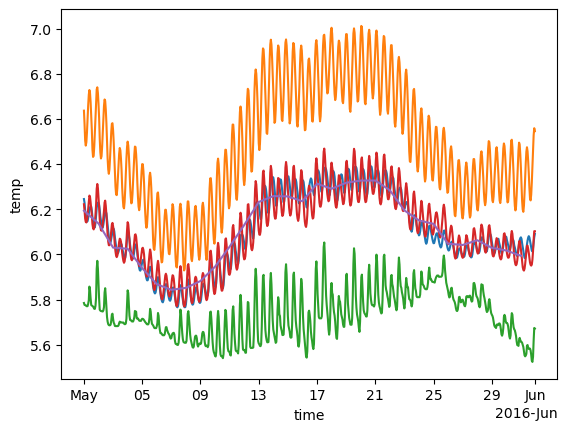

In [6]:
# Looks good!
#ds.temp.isel(node = 33258-1, siglay = -1).plot()

# Get the three node indexes (subtract 1 because its python)
node_indices = [29084-1, 28702-1, 29085-1]  

# Extract timeseries for the given nodes - Get the bottom layer
test_subset = ds["temp"].isel({"node": node_indices, "siglay" : -1})
test_subset.isel(node = 0).plot()
test_subset.isel(node = 1).plot()
test_subset.isel(node = 2).plot()

# # Compute the mean over the three nodes
test_mean_across_nodes = test_subset.mean(dim = "node")  # Now shape: (time,)
test_mean_across_nodes.plot()

# # Convert to daily averages
test_daily_avg = test_mean_across_nodes.resample({"time": "D"}).mean()
test_daily_avg.plot()

### Sigma Layer Count Differences Between Models

It appears that the number of sigma layers changes between FVCOM models. GOM3 has 45 layers, and GOM4 model output appears to only have 40. This could be a reason behind a warm bias.

In [77]:
# # Is siglay different in gom4 vs. gom3, yes
# # In gom4 there are 40 levels, in gom3 there are 45

# # Base URL path
# gom3_base = "http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/Seaplan_33_Hindcast_v1"
# 
# # year/month details
# gom3_yr   = 1978
# gom3_mnth = "01"
# gom3_url  = f"{gom3_base}/gom3_{gom3_yr}{gom3_mnth}.nc"
# gom3 = xr.open_dataset(gom3_url, decode_times=False)
# gom3.coords["siglay"]

### Checking Whether Strata Were Sampled

The first time-saving step is to see if any strata were sampled on dates within the file, if they weren't then we can proceed to the next file.

In [9]:
# # Extract dates from xarray's time coordinate
fvtimes = pd.to_datetime(ds["time"].values).date  # Convert xarray time to just date

# Get row indexing for the dates and the strata that have matches
match_indices = strata_effort_df["time"].isin(fvtimes)
matched_dates = strata_effort_df["time"][match_indices].unique()

# Filter lookup_df to keep only rows where the date exists in ds_dates
filtered_df   = strata_effort_df[match_indices]

# Find the indices in ds["time"] that match any date in strata_effort_df["time"]
fvcom_date_matches = np.where(np.isin(fvtimes, matched_dates))[0]  # Get matched indices

# # # Check nrows
filtered_df.head()

,kipp_stratum,time
76,1_1,2016-05-02
77,1_1,2016-05-04
78,1_1,2016-05-06
206,1_2,2016-05-02
207,1_2,2016-05-03


### Getting Index Info for All Elements in Strata

If a strata was sampled that day, we then want all rows from `strata_overlap_indices` that have `kipp_stratum` matches in the subset.

Using the unique strata ID's we can subset out the rows of the index key table to process:

In [10]:
# From the matches for that day, what strata were sampled?
sampled_strata = filtered_df["kipp_stratum"].unique()

# And what indexes do we want to pull data from:
strata_overlap_indices[strata_overlap_indices["kipp_stratum"].isin(sampled_strata)]

,elem,kipp_stratum,STRATUM,COUNT,REGION,AREA_MILES,PERIMETER_,ACRES,Shape_Leng,Shape_Area,Miles2019,p1,p2,p3
0,56912,4_3,3,71,4,313.660,408.777,200742.130,6.961052,0.091114,312.991767,29084,28702,29085
1,56913,4_3,3,71,4,313.660,408.777,200742.130,6.961052,0.091114,312.991767,29086,29085,28702
2,57628,4_3,3,71,4,313.660,408.777,200742.130,6.961052,0.091114,312.991767,29462,29461,29079
3,57631,4_3,3,71,4,313.660,408.777,200742.130,6.961052,0.091114,312.991767,29462,29081,29463
4,57632,4_4,4,49,4,185.301,259.026,118592.402,4.476669,0.053779,185.007811,29464,29463,29081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5248,91941,1_1,1,68,1,264.823,234.855,169487.030,4.176880,0.062431,217.586603,48384,48385,48601
5249,91942,1_1,1,68,1,264.823,234.855,169487.030,4.176880,0.062431,217.586603,48386,48601,48385
5250,91943,1_1,1,68,1,264.823,234.855,169487.030,4.176880,0.062431,217.586603,48602,48601,48386
5251,91944,1_1,1,68,1,264.823,234.855,169487.030,4.176880,0.062431,217.586603,48387,48602,48386


### Making a List of NECOFS Files and Checking Whether Strata were Sampled

This xhunk of code generates all the URL's for the NECOFS hindcast data into a list. That list can be iterated over to extract data for timesteps we care about:

In [11]:
# List of NetCDF files (adjust pattern as needed)
# Base URL path
necofs_base = "http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/"

# Generate list of URLs for years 2016 to 2023 and months 01 to 12
necofs_urls = [
    f"{necofs_base}{year}/gom4_{year}{month:02d}.nc"
    for year in range(2016, 2024)  # Years 2016 to 2023 (range is exclusive on the end)
    for month in range(1, 13)      # Months 01 to 12 (formatted as two digits)
]

# Print example URLs
necofs_urls[0:6]

['http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/2016/gom4_201601.nc',
 'http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/2016/gom4_201602.nc',
 'http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/2016/gom4_201603.nc',
 'http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/2016/gom4_201604.nc',
 'http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/2016/gom4_201605.nc',
 'http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/2016/gom4_201606.nc']

## What to do when there are dates that match?

The loop below is how one would step through rows in the `strata_overlap_indices`

In [39]:
t_node_set = strata_overlap_indices.loc[0, ["kipp_stratum", "elem", "p1", "p2", "p3"]]
t_node_set[["p1", "p2", "p3"]].values  - 1

array([29083, 28701, 29084], dtype=object)

In [50]:
ds.time.dt.date.values

array([datetime.date(2016, 5, 1), datetime.date(2016, 5, 1), datetime.date(2016, 5, 1), datetime.date(2016, 5, 1), datetime.date(2016, 5, 1),
       datetime.date(2016, 5, 1), datetime.date(2016, 5, 1), datetime.date(2016, 5, 1), datetime.date(2016, 5, 1), datetime.date(2016, 5, 1),
       datetime.date(2016, 5, 1), datetime.date(2016, 5, 1), datetime.date(2016, 5, 1), datetime.date(2016, 5, 1), datetime.date(2016, 5, 1),
       datetime.date(2016, 5, 1), datetime.date(2016, 5, 1), datetime.date(2016, 5, 1), datetime.date(2016, 5, 1), datetime.date(2016, 5, 1),
       datetime.date(2016, 5, 1), datetime.date(2016, 5, 1), datetime.date(2016, 5, 1), datetime.date(2016, 5, 1), datetime.date(2016, 5, 2),
       datetime.date(2016, 5, 2), datetime.date(2016, 5, 2), datetime.date(2016, 5, 2), datetime.date(2016, 5, 2), datetime.date(2016, 5, 2),
       datetime.date(2016, 5, 2), datetime.date(2016, 5, 2), datetime.date(2016, 5, 2), datetime.date(2016, 5, 2), datetime.date(2016, 5, 2),
      

In [60]:
# This is what we want to execute for each file:
data_var = "temp"
siglay_index = -1

#### 1. Loading and Formatting the FVCOM Netcdf  ####

# Open the dataset
ds = xr.open_dataset(necofs_urls[4], decode_times=False)

# Decode byte strings to normal strings
# Convert time to datetime
times_str = ds["Times"].astype(str)  
times_dt = pd.to_datetime(times_str)

# Replace "time" with "Times"
ds = ds.assign_coords(time = ("time", times_dt))  # Assign new time coordinate

# Ensure time is in datetime format and extract only dates
ds_dates = [pd.to_datetime(t).date() for t in ds["time"].values]

# # # Ensure effort_df["date"] is in datetime.date format
strata_effort_df["time"] = pd.to_datetime(strata_effort_df["time"]).dt.date

# Find matching dates in ds["time"]
matching_dates = strata_effort_df["time"][strata_effort_df["time"].isin(ds_dates)].unique()


# Prepare a list to store results
results = []

#### 2.  Loop over the dates that match  ####
# # Iterate over each sampled date
for target_date in matching_dates:
    
    # Get broad areas sampled on this date
    sampled_areas = strata_effort_df.loc[strata_effort_df["time"] == target_date, "kipp_stratum"].unique()

    #### 3. Loop Over the Sampled Strata Separately  ####
    # Process each sampled area separately
    for area in sampled_areas:
        
        # Get node indices for this area from node_index_df
        node_rows = strata_overlap_indices.loc[strata_overlap_indices["kipp_stratum"] == area, ["kipp_stratum", "elem", "p1", "p2", "p3"]]
        
        # Skip if no nodes found for this area
        if node_rows.empty:
            continue  

        area_daily_values = []
        for _, node_set in node_rows.iterrows():
            
            # Extract (p1, p2, p3) as array
            # subtract 1 for dumb python indexing
            nodes = node_set[["p1", "p2", "p3"]].astype(int).values  - 1

            # Extract timeseries for the given nodes - Get the sigma layer of interest
            # Filter time
            ds_subset = ds[data_var].isel({"node": nodes, "siglay" : siglay_index})

            # Filter time - # Get matched indices
            ds_date_matches = np.where(ds_subset.time.dt.date.values == target_date)  
            ds_subset = ds_subset[ds_date_matches]
        
            # Compute the mean over the three nodes
            mean_across_nodes = ds_subset.mean(dim = "node")  # Now shape: (time,)

            # Convert to daily averages
            daily_avg = mean_across_nodes.resample({"time": "D"}).mean()

            # Convert to a DataFrame and store
            df = daily_avg.to_dataframe().reset_index().rename(columns = {"temp": "bot_temp"})
            # Add the element and node info:
            df["elem"] = node_set["elem"]
            df["p1"] = node_set["p1"]
            df["p2"] = node_set["p2"]
            df["p3"] = node_set["p3"]
            area_daily_values.append(df)


        # Combine all node-sets for this area-date
        if area_daily_values:
            area_df = pd.concat(area_daily_values, ignore_index=True)
            area_df["kipp_stratum"] = area
            area_df["date"] = target_date
            results.append(area_df)

# # Combine all results into a single DataFrame
final_df = pd.concat(results, ignore_index=True)


,time,bot_temp,elem,p1,p2,p3,kipp_stratum,date
0,2016-05-02,5.707014,68592,35444,34979,34980,1_1,2016-05-02
1,2016-05-02,5.728904,68593,35444,34980,35445,1_1,2016-05-02
2,2016-05-02,5.760782,68594,35445,34980,35446,1_1,2016-05-02
3,2016-05-02,5.758919,68595,34981,35446,34980,1_1,2016-05-02
4,2016-05-02,5.778267,68599,35448,34982,35449,1_1,2016-05-02


In [61]:
final_df.tail()

,time,bot_temp,elem,p1,p2,p3,kipp_stratum,date
15722,2016-05-31,7.160227,70076,36278,35767,35768,5_3,2016-05-31
15723,2016-05-31,6.889626,71016,36275,36277,36804,5_3,2016-05-31
15724,2016-05-31,6.878141,71018,36804,36277,36805,5_3,2016-05-31
15725,2016-05-31,6.932243,71019,36277,36806,36805,5_3,2016-05-31
15726,2016-05-31,7.046412,71020,36806,36277,36278,5_3,2016-05-31


In [66]:
# Save to check it!
short_name = necofs_urls[4].replace("http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/", "").replace(".nc", ".csv").rsplit("/", 1)[1]
month_save = f"local_data/LSAG_requests/NECOFS_Concurrent_Daily_Btemp/MENH_Sampled_Strata_btemp_{short_name}"
final_df.to_csv(month_save, index=False)

# Process Matches Across Multiple Files

This is the big loop that will step through each of the NECOFS files. Fingers crossed...

In [68]:
####
# These are configuration options we want to execute for each file:
data_var = "temp"
siglay_index = -1
####


# Loop through each NetCDF file
for file in necofs_urls[0:5]:
    
    #### 1. Loading and Formatting the FVCOM Netcdf  ####

    # Open the dataset
    ds = xr.open_dataset(file, decode_times=False)
    short_name = file.replace("http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/", "").replace(".nc", ".csv").rsplit("/", 1)[1]

    # Decode byte strings to normal strings
    # Convert time to datetime
    times_str = ds["Times"].astype(str)  
    times_dt = pd.to_datetime(times_str)

    # Replace "time" with "Times"
    ds = ds.assign_coords(time = ("time", times_dt))  # Assign new time coordinate

    # Ensure time is in datetime format and extract only dates
    ds_dates = [pd.to_datetime(t).date() for t in ds["time"].values]

    # # # Ensure effort_df["date"] is in datetime.date format
    strata_effort_df["time"] = pd.to_datetime(strata_effort_df["time"]).dt.date

    # Find matching dates in ds["time"]     
    time_index_matches = strata_effort_df["time"].isin(ds_dates)

    # If no matches, skip to the next file
    if not time_index_matches.any():  
        print(f"No matched dates in {short_name}, skipping...")
        # Close dataset to free memory
        ds.close()  
        continue



    # If they do exist, get them to loop through
    print(f"Processing Date Matches from: {short_name}")
    matching_dates = strata_effort_df["time"][time_index_matches].unique()

    # Prepare a list to store results
    results = []

    #### 2.  Loop over the dates that match  ####
    # # Iterate over each sampled date
    for target_date in matching_dates:
        
        # Get broad areas sampled on this date
        sampled_areas = strata_effort_df.loc[strata_effort_df["time"] == target_date, "kipp_stratum"].unique()

        #### 3. Loop Over the Sampled Strata Separately  ####
        # Process each sampled area separately
        for area in sampled_areas:
            
            # Get node indices for this area from node_index_df
            node_rows = strata_overlap_indices.loc[strata_overlap_indices["kipp_stratum"] == area, ["kipp_stratum", "elem", "p1", "p2", "p3"]]
            
            # Skip if no nodes found for this area
            if node_rows.empty:
                continue  

            area_daily_values = []
            for _, node_set in node_rows.iterrows():
                
                # Extract (p1, p2, p3) as array
                # subtract 1 for dumb python indexing
                nodes = node_set[["p1", "p2", "p3"]].astype(int).values  - 1

                # Extract timeseries for the given nodes - Get the sigma layer of interest
                # Filter time
                ds_subset = ds[data_var].isel({"node": nodes, "siglay" : siglay_index})

                # Filter time - # Get matched indices
                ds_date_matches = np.where(ds_subset.time.dt.date.values == target_date)  
                ds_subset = ds_subset[ds_date_matches]
            
                # Compute the mean over the three nodes
                mean_across_nodes = ds_subset.mean(dim = "node")  # Now shape: (time,)

                # Convert to daily averages
                daily_avg = mean_across_nodes.resample({"time": "D"}).mean()

                # Convert to a DataFrame and store
                df = daily_avg.to_dataframe().reset_index().rename(columns = {"temp": "bot_temp"})
                
                # Add the element and node info:
                df["elem"] = node_set["elem"]
                df["p1"] = node_set["p1"]
                df["p2"] = node_set["p2"]
                df["p3"] = node_set["p3"]
                area_daily_values.append(df)


            # Combine all node-sets for this area-date
            if area_daily_values:
                area_df = pd.concat(area_daily_values, ignore_index=True)
                area_df["kipp_stratum"] = area
                area_df["date"] = target_date
                results.append(area_df)

    # # Combine all results into a single DataFrame
    final_df = pd.concat(results, ignore_index=True)

    # Save the File
    month_save = f"local_data/LSAG_requests/NECOFS_Concurrent_Daily_Btemp/MENH_Sampled_Strata_btemp_{short_name}"
    final_df.to_csv(month_save, index=False)

    # Close the dataset to free memory
    ds.close()


No matched dates in http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/2016/gom4_201601.nc, skipping...
No matched dates in http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/2016/gom4_201601.nc, skipping...


No matched dates in http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/2016/gom4_201602.nc, skipping...
No matched dates in http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/2016/gom4_201602.nc, skipping...


No matched dates in http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/2016/gom4_201603.nc, skipping...
No matched dates in http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/2016/gom4_201603.nc, skipping...


No matched dates in http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/2016/gom4_201604.nc, skipping...
No matched dates in http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/2016/gom4_201604.nc, skipping...


----
# Scrap heap

There was a lot of iteration.

In [67]:
#### OLD VERSION  ####


# # Loop through each NetCDF file
# for file in necofs_urls:
    
    
#     print(f"Processing {file}...")

#     #### 1. Loading and Formatting the FVCOM Netcdf  ####
#     # Open the dataset
#     ds = xr.open_dataset(file, decode_times=False)

#     # Decode byte strings to normal strings
#     # Convert time to datetime
#     times_str = ds["Times"].astype(str)  
#     times_dt = pd.to_datetime(times_str)
    
#     # Replace "time" with "Times"
#     ds = ds.assign_coords(time = ("time", times_dt))  # Assign new time coordinate

#     # Ensure time is in datetime format and extract only dates
#     ds_dates = [pd.to_datetime(t).date() for t in ds["time"].values]


#     #### 2.   ####

#     # Get row indexing for the dates and the strata that have matches
#     match_indices = strata_effort_df["time"].isin(ds_dates)

#     # If no matches, skip to the next file
#     if not match_indices.any():  
#         print(f"No matched dates in {file}, skipping...")
#         # Close dataset to free memory
#         ds.close()  
#         continue

#     # If matches found, subset the strata sampled
#     print(f"Matching dates in {file}, processing...")

#     # Filter lookup_df to keep only rows where the date exists in ds_dates
#     matched_rows = strata_effort_df[match_indices]

#     # Find the indices in ds["time"] that match any date in matched_rows["time"]
#     matched_dates = strata_effort_df["time"][match_indices].unique()
#     ds_date_matches = np.where(np.isin(ds_dates, matched_dates))[0]  # Get matched indices

#     # Use the mesh * strata overlap key to get the indexing information for those strata
#     sampled_strata = matched_rows["kipp_stratum"].unique()
#     match_index_key = strata_overlap_indices[strata_overlap_indices["kipp_stratum"].isin(sampled_strata)]


#     # # Perform your processing steps here...
#     # Iterate over each row in the lookup table (use .head(5) to test first few)
#     for _, row in match_index_key.iterrows():
        
#         # The element it falls within
#         elem_id = row["elem"]
        
#         # Get the three node indexes (subtract 1 because its python)
#         node_indices = [row["p1"]-1, row["p2"]-1, row["p3"]-1]  
            
#         # Extract timeseries for the given nodes - Get the sigma layer of interest
#         subset = ds[data_var].isel({"node": node_indices, "siglay" : siglay_index})

#         # Filter time
#         subset = subset.isel(time = ds_date_matches)
    
#         # Compute the mean over the three nodes
#         mean_across_nodes = subset.mean(dim = "node")  # Now shape: (time,)

#         # Convert to daily averages
#         daily_avg = mean_across_nodes.resample({"time": "D"}).mean()

#         # Convert to a DataFrame and store
#         df = daily_avg.to_dataframe().reset_index().rename(columns = {"temp": "bot_temp"})
        
#         # Add the ID for reference
#         df["elem"] = elem_id
#         df["p1"] = row["p1"]
#         df["p2"] = row["p2"]
#         df["p3"] = row["p3"]
#         results.append(df)

#         # Close dataset after processing
#         ds.close()


    